In [2]:
%matplotlib inline

In [31]:
# General imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



# GLOBAL CONSTANTS
GFACTORCONSTANT = 1.3996e-5  # 1/(ps*mTesla), = bohr magneton/2*pi*hbar
LASER_REPRATE = 13158  # ps period


# %%
def get_pulse_sum_vector(bfield, spin_lifetime, gfactor, initial_phase=0):
    """
    Determines effect of summed spins over many pulses and returns the net
    phase and amplitude at zero time delay expected to result. Does not
    take into account any b-field-axis zeeman polarization of spins/nuclei,
    or high-intensity polarization saturation and/or repolarization effects.

    Formulae are from Chris Trowbridge's Ph.D. thesis,
    eqns. 5.12, 5.13, 5.29, and 5.30.

    Does not handle more than one species, so run this function on each
    species individually if possible.

    Expected units:
    polarization: unitless scalar in [0, 1]
    lifetime: ps
    """
    osc_ang_freq = 2 * np.pi * GFACTORCONSTANT * gfactor * bfield
    theta = osc_ang_freq * LASER_REPRATE
    x = LASER_REPRATE / spin_lifetime
    net_amplitude = 1. / np.sqrt(1 - 2 * np.exp(-x) * np.cos(theta) +
                                 np.exp(-2 * x))
    net_phase = initial_phase + np.arctan((np.exp(-x) * np.sin(theta)) /
                                          (1 - np.exp(-x) * np.cos(theta)))
    return (net_amplitude, net_phase)  # at zero delay, of course


# %%
def trkr_decaying_cosine(delay_time, total_bfield,
                         pulse_amplitude,
                         gfactor, spin_lifetime,
                         initial_phase, extra_phase_offset,
                         slope, offset):
    zero_delay_offset = 0.0
    pos_def_delay = (delay_time + zero_delay_offset) % LASER_REPRATE
    osc_ang_freq = 2 * np.pi * GFACTORCONSTANT * gfactor * total_bfield
    net_polarization, net_phase = get_pulse_sum_vector(spin_lifetime,
                                                       gfactor, total_bfield,
                                                       initial_phase)
    final_phase = (net_phase + pos_def_delay * osc_ang_freq) % (2 * np.pi)
    final_amplitude = pulse_amplitude * net_polarization * \
                            np.exp(-pos_def_delay / spin_lifetime)
    signal = final_amplitude * np.cos(final_phase + extra_phase_offset)
    output = signal + delay_time * slope + offset  # NOT pos-definite
    return output


# %%
def generate_TRKR_simulation_params(nxvals, ndatasets,
                                    simulation_constants, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # extract the parameters used to determine the parameters
    pulse_amplitude_mean = simulation_constants['pulse_amplitude_mean']
    pulse_amplitude_std_err = simulation_constants['pulse_amplitude_std_err']
    gfactor = simulation_constants['gfactor']
    spin_lifetime_mean = simulation_constants['spin_lifetime_mean']
    spin_lifetime_std_err = simulation_constants['spin_lifetime_std_err']
    initial_phase = simulation_constants['initial_phase']
    extra_phase_offset_baseline = simulation_constants['extra_phase_offset_baseline']
    extra_phase_offset_cos_amp = simulation_constants['extra_phase_offset_cos_amp']
    extra_phase_offset_cos_nperiods = simulation_constants['extra_phase_offset_cos_nperiods']
    slopes_scale = simulation_constants['slopes_scale']
    offsets_scale = simulation_constants['offsets_scale']
    noise_scale = simulation_constants['noise_scale']

    # generate actual parameter values for each simulated dataset
    pulse_amplitudes = pulse_amplitude_mean + \
                        np.random.normal(size=ndatasets, scale=pulse_amplitude_std_err)
    gfactors = gfactor * np.ones(ndatasets)
    spin_lifetimes = spin_lifetime_mean + \
                        np.random.normal(size=ndatasets, scale=spin_lifetime_std_err)
    initial_phases = initial_phase * np.ones(ndatasets)
    extra_phase_offsets = \
        (extra_phase_offset_baseline + extra_phase_offset_cos_amp *
            np.sin((2 * np.pi * extra_phase_offset_cos_nperiods / ndatasets) *
                                                               np.arange(ndatasets)))
    slopes = np.random.normal(size=ndatasets, scale=slopes_scale)
    offsets = np.random.normal(size=ndatasets, scale=offsets_scale)
    noisefcn = lambda nx: np.random.normal(size=nx, scale=noise_scale)
    noise_layers = [noisefcn(nxvals) for dataset_index in range(ndatasets)]
    dataset_model_params_dicts = \
        [{'pulse_amplitude'    : pulse_amplitudes[dataset_index],
          'gfactor'            : gfactors[dataset_index],
          'spin_lifetime'      : spin_lifetimes[dataset_index],
          'initial_phase'      : initial_phases[dataset_index],
          'extra_phase_offset' : extra_phase_offsets[dataset_index],
          'slope'              : slopes[dataset_index],
          'offset'             : offsets[dataset_index]}
         for dataset_index in range(ndatasets)]
    simulation_params = {
        'dataset_model_params_dicts': dataset_model_params_dicts,
        'noise_layers': noise_layers,
    }
    return simulation_params


# %%
def generate_TRKR_simulation_dataframe(tvals, dataset_bvals, simulation_params,
                                       suppress_plot=False):
    """For function trkr_decaying_cosine() in this module"""
    nx = len(tvals)
    ndatasets = len(dataset_bvals)
    indices_1d = np.arange(nx)
    indices_2d = np.arange(ndatasets)
    dataset_model_params_dicts = simulation_params['dataset_model_params_dicts']
    noise_layers = simulation_params['noise_layers']
    scan_1d_results= []
    for index_2d in indices_2d:
        delay_times = tvals
        dataset_b_external = dataset_bvals[index_2d]
        dataset_params_dict = dataset_model_params_dicts[index_2d]
        yvals = trkr_decaying_cosine(delay_times,
                                     dataset_b_external,
                                     **dataset_params_dict)
        noisy_yvals = yvals + noise_layers[index_2d]
        scan_1d_results.append(noisy_yvals)
    X_bvals, X_tvals = np.meshgrid(dataset_bvals, tvals, indexing='ij',
                                   sparse=False, copy=True)  # not sure on ideal settings here
    independent_data_matrices = [X_tvals, X_bvals]
    measured_data = np.array(scan_1d_results)

    plt.imshow(measured_data, interpolation='none', aspect=nx/ndatasets)

    # pandas dataframe conversion
    run_ids = np.zeros(measured_data.size, dtype=np.int)
    indices_2d, indices_1d = np.meshgrid(np.arange(len(dataset_bvals)),
                                         np.arange(len(tvals)),
                                         indexing='ij', sparse=False, copy=True)
    dataframe = pd.DataFrame({'run_id'        : run_ids,
                              'index_2d'      : indices_2d.flatten(),
                              'index_1d'      : indices_1d.flatten(),
                              'b_external'    : X_bvals.flatten(),
                              'probe_delay'   : X_tvals.flatten(),
                              'kerr_rotation' : measured_data.flatten(),
                             })
    dataframe.set_index(['run_id', 'index_2d', 'index_1d'], drop=True, append=False, inplace=True)
    dataframe.sort_index(ascending=True, inplace=True)  # not actually necessary, but nice to be sure
    return dataframe

b_external  kerr_rotation  probe_delay
run_id index_2d index_1d                                        
0      0        0              200.0      -0.000366       -500.0
                1              200.0      -0.000228       -420.0
                2              200.0      -0.000053       -340.0
                3              200.0       0.000229       -260.0
                4              200.0       0.000152       -180.0

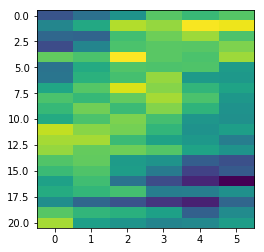

In [33]:
# independent params
seed = 11
ndatasets = 21
nx = 6
dataset_bvals = np.linspace(200, 208, ndatasets)
tvals = np.linspace(-500, -100, nx)

# simulation constants & randomly generated params
simulation_constants = {
    'pulse_amplitude_mean': 1e-3,
    'pulse_amplitude_std_err': 2e-5,
    'gfactor': 0.439,
    'spin_lifetime_mean': 10000,
    'spin_lifetime_std_err': 2000,
    'initial_phase': 0.0 * np.pi,
    'extra_phase_offset_baseline': 0.0 * np.pi,
    'extra_phase_offset_cos_amp': 0.0 * np.pi,
    'extra_phase_offset_cos_nperiods': 1.0,
    'slopes_scale': 0.0,
    'offsets_scale': 1e-4,
    'noise_scale': 1e-4
}

simulation_params = generate_TRKR_simulation_params(nx, ndatasets, simulation_constants, seed)
dataframe = generate_TRKR_simulation_dataframe(tvals, dataset_bvals,
                                               simulation_params,
                                               suppress_plot=False)
dataframe.head()